## CH5.S1: Bivariate copulas for claims by type

This script will be divided into two parts:

1. Copulas for raw claims by type
2. Copulas for detrended claims by type

In [1]:
#loading the required libraries:
import copulas as copulas
import pycop
import time
import numpy as np
import itertools
import random
from statistics import mean 
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as ss


#changing the plot configuration:
plt.rcParams['figure.figsize'] = (5, 5)
plt.style.use('seaborn')

### PART 1. COPULAS FOR RAW CLAIMS BY TYPE

In [2]:
# loading the raw claims dataset:
df = pd.read_csv("C:/Users/r_jun/Documents/ISEG MSc Actuarial Science/Thesis/Python/FINAL/CH4/Raw by Type/aggregated_series.csv")
df.describe()

,pdx,pds,plx,pls,cbx,cbs,cpx,cps
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,229.743590,43393.384423,255.448718,45801.327436,388.096154,59298.647628,120.897436,37450.703013
std,182.140955,23012.955179,208.589651,41028.606035,377.259229,59463.309234,56.016954,18528.229545
min,15.000000,4465.960000,14.000000,2033.880000,14.000000,1964.960000,14.000000,4121.360000
25%,127.750000,30391.940000,112.750000,18697.077500,157.250000,23802.515000,87.750000,26471.802500
50%,150.000000,37980.400000,152.000000,26495.180000,196.000000,30811.005000,105.500000,34139.190000
75%,259.500000,53313.577500,377.000000,62260.750000,507.500000,77035.832500,150.000000,46662.660000
max,873.000000,133835.070000,1007.000000,196328.290000,1670.000000,261424.430000,337.000000,137850.990000


#### 1. Empirical Tail Dependence Coefficients

In [3]:
#PLX and PDX:
pd.set_option('mode.chained_assignment',None)
from pycop.bivariate.copula import empirical
cop1 = empirical(df[['pdx', 'plx']])
print(cop1.optimal_tdc("upper"), cop1.UTDC(0.90))

Optimal threshold:  0.21794871794871795
0.8370524201546382 0.6538461538461527


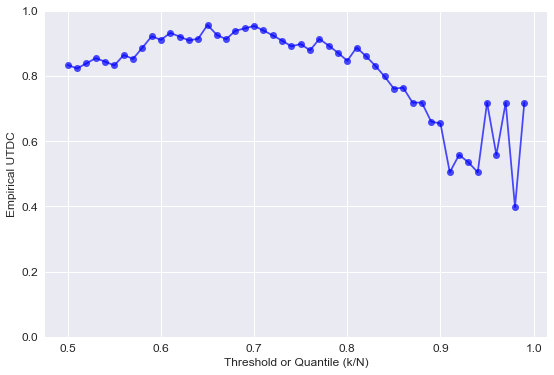

In [5]:
#plotting the empirical tail coefficients for this pair of variables:
x = np.linspace(0.5, 0.99, 50)
utdc = []
for i in x:
    utdc.append(cop1.UTDC(i))
fig,ax = plt.subplots(figsize=(9,6))
ax.set_ylim(0,1)
plt.plot(x, utdc, 'b-o', alpha=0.7)
plt.ylabel('Empirical UTDC', fontsize=12)
plt.xlabel('Threshold or Quantile (k/N)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('etdc_thresholds.png', dpi=300, bbox_inches='tight')

In [6]:
#PLS and PDS:
from pycop.bivariate.copula import empirical
cop2 = empirical(df[['pds', 'pls']])
print(cop2.optimal_tdc("upper"), cop2.UTDC(0.90))

Optimal threshold:  0.2692307692307692
0.8546644906998909 0.7179487179487177


In [7]:
#PDX and PDS:
from pycop.bivariate.copula import empirical
cop3 = empirical(df[['pdx', 'pds']])
print(cop3.optimal_tdc("upper"), cop3.UTDC(0.90))

Optimal threshold:  0.47435897435897434
0.7959913649070055 0.9102564102564095


In [8]:
#PLX and PLS:
from pycop.bivariate.copula import empirical
cop4 = empirical(df[['plx', 'pls']])
print(cop4.optimal_tdc("upper"), cop4.UTDC(0.90))

Optimal threshold:  0.3141025641025641
0.8757710700049061 0.9743589743589733


#### 2. Fitting Archimedean copulas

To find the best Archimedean copulas, the marginals will be fit in pairs and then tested using select() from the copulas library

In [9]:
#adding the marginals to the existing dataframe:
df['Fpdx'] = ss.nbinom.cdf(df['pdx'], 2.139883173181995, 0.00922814420430195)
df['Fplx'] = ss.nbinom.cdf(df['plx'], 1.7579089737306162, 0.006834721956499432)
df['Fpds'] = ss.loglaplace.cdf(df['pds'], 2.481704232311386, 0, 37891.93289315458)
df['Fpls'] = ss.lognorm.cdf(df['pls'],  0.9086819314521254, 0.0, 31402.11730335455)
df.iloc[:,9:].head()

,Fpdx,Fplx,Fpds,Fpls
0,0.656474,0.384473,0.719151,0.683863
1,0.810250,0.489878,0.804214,0.682261
2,0.841280,0.732862,0.854039,0.852466
3,0.868594,0.825312,0.897929,0.877162
4,0.837948,0.719966,0.849656,0.803230


**1. PDX AND PLX**

In [46]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
#Selecting the best copula for pdx and plx 
from copulas.bivariate import select_copula 
X1 = df[['Fpdx', 'Fplx']].to_numpy()
X1.shape
select_copula(X1)

In [47]:
#fitting the Gumbel copula and printing tau and the estimated parameter:
from copulas.bivariate import Bivariate
dist1 = Bivariate(copula_type='gumbel')
dist1.fit(X1)
dist1.tau, dist1.theta

(0.7171784454627369, 3.535798399935056)

In [48]:
#checking upper and lower tail dependency:
from pycop.bivariate.copula import archimedean
cop1 = archimedean(family="gumbel")
cop1.LTDC(theta=dist1.theta), cop1.UTDC(theta=dist1.theta) 

(0, 0.7834281271935828)

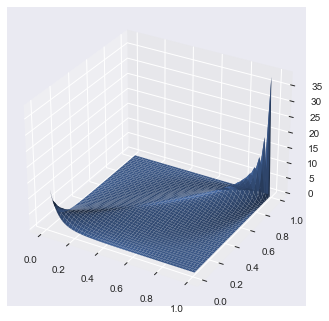

In [53]:
cop1.plot_pdf(theta=dist1.theta, Nsplit=50)

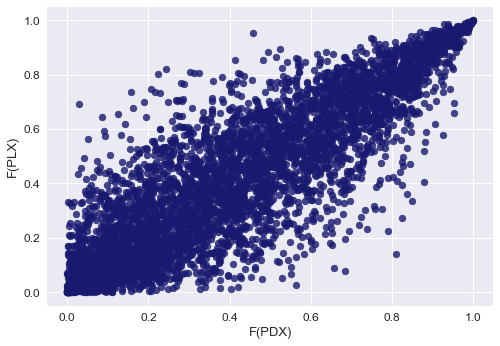

In [45]:
#simulating with this Gumbel copula
from pycop.bivariate import simulation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn') 
u1, u2 = simulation.simu_gumbel(num=5000, theta=dist1.theta)
plt.scatter(u1, u2, color="midnightblue", alpha=0.8)
plt.xlabel("F(PDX)", fontsize=13)
plt.ylabel("F(PLX)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('cop_pdx_plx.png', dpi=300, bbox_inches='tight')

**2. PDS AND PLS**

In [54]:
#Selecting the best copula for pds and pls 
from copulas.bivariate import select_copula 
X2 = df[['Fpds', 'Fpls']].to_numpy()
X2.shape
select_copula(X2)

In [55]:
#fitting the Frank copula and printing tau and the estimated parameter:
from copulas.bivariate import Bivariate
dist2 = Bivariate(copula_type='Clayton')
dist2.fit(X2)
dist2.tau, dist2.theta

(0.6314309346567412, 3.426391382405746)

In [56]:
#checking upper and lower tail dependency:
cop2 = archimedean(family="clayton")
cop2.LTDC(theta=dist2.theta), cop2.UTDC(theta=dist2.theta) 

(0.81685264841827, 0)

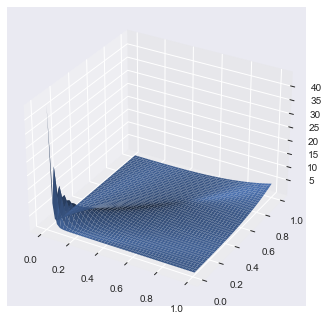

In [58]:
cop2.plot_pdf(theta=dist2.theta, Nsplit=50)

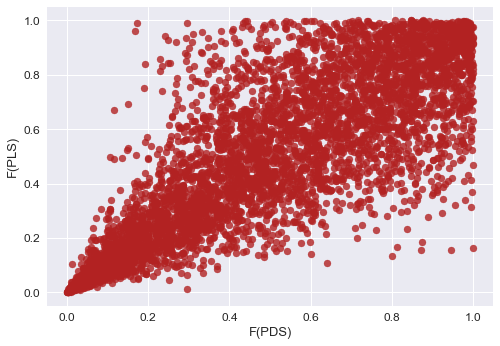

In [15]:
#simulating with this Frank copula
from pycop.bivariate import simulation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn') 
u1, u2 = simulation.simu_clayton(num=5000, theta=dist2.theta)
plt.scatter(u1, u2, color="firebrick", alpha=0.8)
plt.xlabel("F(PDS)", fontsize=13)
plt.ylabel("F(PLS)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('cop_pds_pls.png', dpi=300, bbox_inches='tight')

**3. PDX AND PDS**

In [59]:
#Selecting the best copula for pdx and pds 
from copulas.bivariate import select_copula 
X3 = df[['Fpdx', 'Fpds']].to_numpy()
X3.shape
select_copula(X3)

In [60]:
#fitting the Gumbel copula and printing tau and the estimated parameter:
from copulas.bivariate import Bivariate
dist3 = Bivariate(copula_type='gumbel')
dist3.fit(X3)
dist3.tau, dist3.theta

(0.7536159781732004, 4.058704751166734)

In [61]:
#checking upper and lower tail dependency:
cop3 = archimedean(family="gumbel")
cop3.LTDC(theta=dist3.theta), cop3.UTDC(theta=dist3.theta) 

(0, 0.8137697875261753)

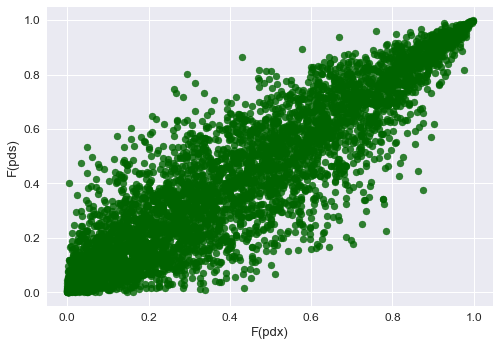

In [19]:
#simulating with this Gumbel copula
from pycop.bivariate import simulation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn') 
u1, u2 = simulation.simu_gumbel(num=5000, theta=dist3.theta)
plt.scatter(u1, u2, color="darkgreen", alpha=0.8)
plt.xlabel("F(pdx)", fontsize=13)
plt.ylabel("F(pds)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('cop_pdx_pds.png', dpi=300, bbox_inches='tight')

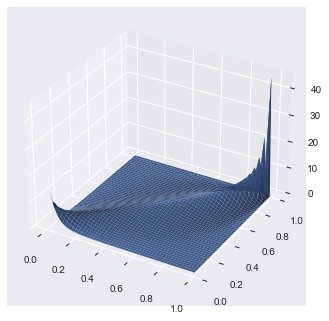

In [62]:
cop3.plot_pdf(theta=dist3.theta, Nsplit=50)

**4. PLX AND PLS**

In [63]:
#Selecting the best copula for plx and pls 
from copulas.bivariate import select_copula 
X4 = df[['Fplx', 'Fpls']].to_numpy()
X4.shape
select_copula(X4)

In [64]:
#fitting the Gumbel copula and printing tau and the estimated parameter:
from copulas.bivariate import Bivariate
dist4 = Bivariate(copula_type='gumbel')
dist4.fit(X4)
dist4.tau, dist4.theta

(0.8425640512077406, 6.351789458959748)

In [65]:
#checking upper and lower tail dependency:
cop4 = archimedean(family="gumbel")
cop4.LTDC(theta=dist4.theta), cop4.UTDC(theta=dist4.theta) 

(0, 0.8846968135769013)

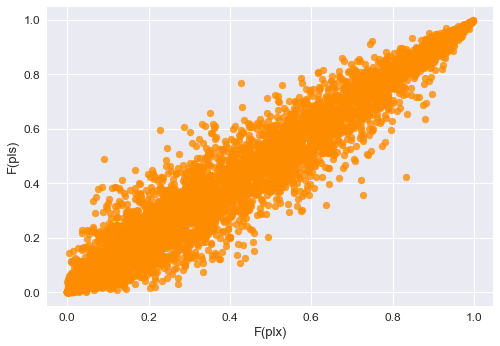

In [23]:
#simulating with this Gumbel copula
from pycop.bivariate import simulation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn') 
u1, u2 = simulation.simu_gumbel(num=5000, theta=dist4.theta)
plt.scatter(u1, u2, color="darkorange", alpha=0.8)
plt.xlabel("F(plx)", fontsize=13)
plt.ylabel("F(pls)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('cop_plx_pls.png', dpi=300, bbox_inches='tight')

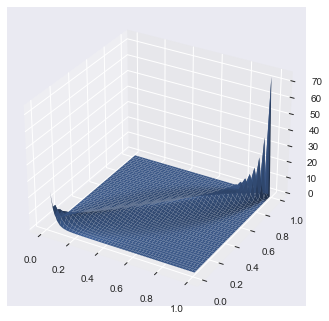

In [66]:
cop4.plot_pdf(theta=dist4.theta, Nsplit=50)

### PART 2. COPULAS FOR DETRENDED CLAIMS BY TYPE

In [68]:
#loading the detrended series:
df = pd.read_csv("C:/Users/r_jun/Documents/ISEG MSc Actuarial Science/Thesis/Python/FINAL/CH4/Detrended by Type/aggregated_detrended_series.csv")
df.describe()

,Unnamed: 0,pdx,pds,plx,pls,cbx,cbs,cpx,cps
count,156.000000,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02
mean,77.500000,3.753123e-14,1.770017e-11,-1.552263e-13,2.938367e-12,5.757218e-14,8.581899e-12,-3.666583e-15,2.775125e-12
std,45.177428,8.981529e+01,1.394064e+04,1.167014e+02,2.230552e+04,1.980951e+02,3.275734e+04,2.876242e+01,1.251592e+04
min,0.000000,-4.223615e+02,-4.634860e+04,-4.378416e+02,-7.900797e+04,-1.036661e+03,-1.651316e+05,-8.746980e+01,-2.681667e+04
25%,38.750000,-3.907830e+01,-6.181272e+03,-7.741136e+01,-1.125709e+04,-8.708965e+01,-1.401144e+04,-1.350966e+01,-8.766360e+03
50%,77.500000,1.889838e+00,8.814776e+02,-2.758647e+00,-2.496194e+03,-1.386099e+00,-2.069880e+03,2.265712e+00,1.125036e+02
75%,116.250000,3.550041e+01,5.587979e+03,7.064126e+01,1.019178e+04,8.913627e+01,1.233685e+04,1.582114e+01,6.153436e+03
max,155.000000,3.640041e+02,5.674145e+04,4.779544e+02,9.445369e+04,7.507874e+02,1.196577e+05,1.289910e+02,7.465435e+04


In [71]:
#PLX and PDX:
pd.set_option('mode.chained_assignment',None)
from pycop.bivariate.copula import empirical
cop1 = empirical(df[['pdx', 'plx']])
cop1.UTDC(0.90)

0.5897435897435889

In [72]:
#PDS and PLS:
pd.set_option('mode.chained_assignment',None)
from pycop.bivariate.copula import empirical
cop2 = empirical(df[['pds', 'pls']])
cop2.UTDC(0.90)

0.4615384615384611

In [73]:
#PDX and PDS:
pd.set_option('mode.chained_assignment',None)
from pycop.bivariate.copula import empirical
cop3 = empirical(df[['pdx', 'pds']])
cop3.UTDC(0.90)

0.6538461538461527

In [74]:
#PLX and PLS:
pd.set_option('mode.chained_assignment',None)
from pycop.bivariate.copula import empirical
cop4 = empirical(df[['plx', 'pls']])
cop4.UTDC(0.90)

0.8461538461538456

#### 1. Fitting Archimedean copulas

To find the best Archimedean copulas, the marginals will be fit in pairs and then tested using select() from the copulas library

In [69]:
#adding the marginals to the detrended claims by type:
df['Fpdx'] = ss.t.cdf(df['pdx'], df=2.331890618597993, loc=0.6018809564047002, scale=45.40661098100092)
df['Fplx'] = ss.nct.cdf(df['plx'], 4.960538915142913, 0.15778378306733729, -16.622885444080023, 89.6489619604276)
df['Fpds'] = ss.johnsonsu.cdf(df['pds'], 0.10969438260416041, 1.0468429582363932, 1211.5906573050079, 9305.032853814784)
df['Fpls'] = ss.nct.cdf(df['pls'], 2.36318439656056, 0.6603089079082696, -11186.72718206899, 11886.154612459231)
df.iloc[:,9:].head()

,Fpdx,Fplx,Fpds,Fpls
0,0.003389,0.001918,0.009807,0.002887
1,0.006431,0.003091,0.016951,0.003035
2,0.008602,0.015807,0.030397,0.015043
3,0.012056,0.052009,0.075973,0.032125
4,0.010324,0.015608,0.035481,0.008571


**1. DPDX AND DPLX**

In [27]:
#Selecting the best copula for dpdx and dplx 
from copulas.bivariate import select_copula 
X1 = df[['Fpdx', 'Fplx']].to_numpy()
X1.shape
select_copula(X1)

In [28]:
#fitting the Clayton copula and printing tau and the estimated parameter:
from copulas.bivariate import Bivariate
dist1 = Bivariate(copula_type='clayton')
dist1.fit(X1)
dist1.tau, dist1.theta

(0.509181141439206, 2.0748230535894847)

In [29]:
#checking upper and lower tail dependency:
from pycop.bivariate.copula import archimedean
cop1 = archimedean(family="clayton")
cop1.LTDC(theta=dist1.theta), cop1.UTDC(theta=dist1.theta) 

(0.7159998493658684, 0)

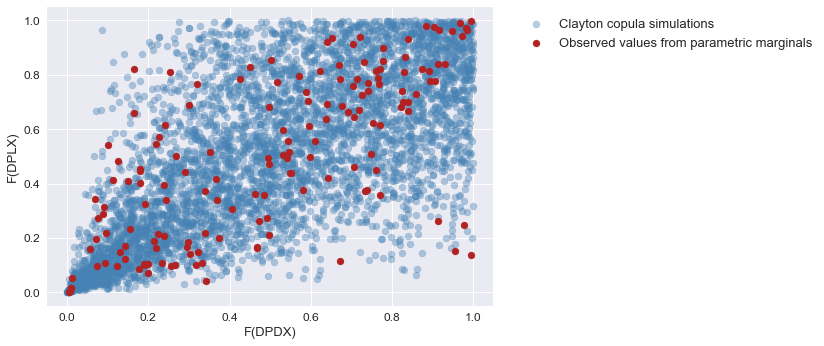

In [30]:
#simulating with this Clayton copula
from pycop.bivariate import simulation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn') 
u1, u2 = simulation.simu_clayton(num=5000, theta=dist1.theta)
plt.scatter(u1, u2, color="steelblue", alpha=0.4, label="Clayton copula simulations")
plt.scatter(df['Fpdx'], df['Fplx'], color="firebrick", label="Observed values from parametric marginals")
plt.xlabel("F(DPDX)", fontsize=13)
plt.ylabel("F(DPLX)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize=13)
plt.savefig('cop_comparison_dtypes.png', dpi=300, bbox_inches='tight')

**2. DPDS AND DPLS**

In [31]:
#Selecting the best copula for dpds and dpls 
from copulas.bivariate import select_copula 
X2 = df[['Fpds', 'Fpls']].to_numpy()
X2.shape
select_copula(X2)

In [32]:
#fitting the Gumbel copula and printing tau and the estimated parameter:
from copulas.bivariate import Bivariate
dist2 = Bivariate(copula_type='gumbel')
dist2.fit(X2)
dist2.tau, dist2.theta

(0.37849462365591396, 1.6089965397923873)

In [33]:
#checking upper and lower tail dependency:
from pycop.bivariate.copula import archimedean
cop2 = archimedean(family="gumbel")
cop2.LTDC(theta=dist2.theta), cop2.UTDC(theta=dist2.theta) 

(0, 0.46152033339581666)

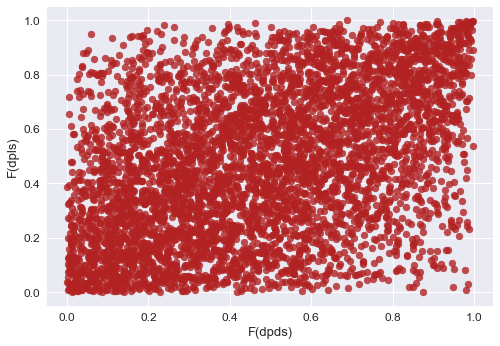

In [34]:
#simulating with this Gumbel copula
from pycop.bivariate import simulation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn') 
u1, u2 = simulation.simu_gumbel(num=5000, theta=dist2.theta)
plt.scatter(u1, u2, color="firebrick", alpha=0.8)
plt.xlabel("F(dpds)", fontsize=13)
plt.ylabel("F(dpls)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('cop_dpds_dpls.png', dpi=300, bbox_inches='tight')

**3. DPDX AND DPLX**

In [35]:
#Selecting the best copula for dpdx and dpds 
from copulas.bivariate import select_copula 
X3 = df[['Fpdx', 'Fpds']].to_numpy()
X3.shape
select_copula(X3)

In [36]:
#fitting the Gumbel copula and printing tau and the estimated parameter:
from copulas.bivariate import Bivariate
dist3 = Bivariate(copula_type='gumbel')
dist3.fit(X3)
dist3.tau, dist3.theta

(0.5892473118279571, 2.43455497382199)

In [37]:
#checking upper and lower tail dependency:
from pycop.bivariate.copula import archimedean
cop3 = archimedean(family="gumbel")
cop3.LTDC(theta=dist3.theta), cop3.UTDC(theta=dist3.theta) 

(0, 0.6706207981826209)

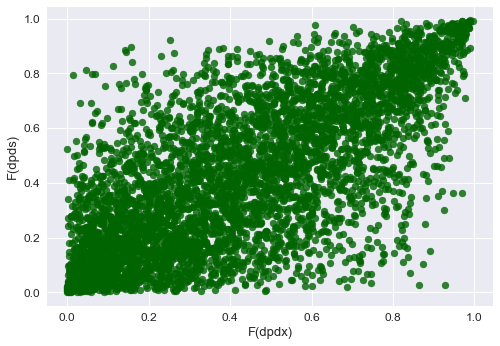

In [38]:
#simulating with this Gumbel copula
from pycop.bivariate import simulation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn') 
u1, u2 = simulation.simu_gumbel(num=5000, theta=dist3.theta)
plt.scatter(u1, u2, color="darkgreen", alpha=0.8)
plt.xlabel("F(dpdx)", fontsize=13)
plt.ylabel("F(dpds)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('cop_dpdx_dpds.png', dpi=300, bbox_inches='tight')

**4. DPLX AND DPLS**

In [39]:
#Selecting the best copula for dplx and dpls 
from copulas.bivariate import select_copula 
X4 = df[['Fplx', 'Fpls']].to_numpy()
X4.shape
select_copula(X4)

In [40]:
#fitting the Clayton copula and printing tau and the estimated parameter:
from copulas.bivariate import Bivariate
dist4 = Bivariate(copula_type='clayton')
dist4.fit(X4)
dist4.tau, dist4.theta

(0.766914805624483, 6.580553584102199)

In [41]:
#checking upper and lower tail dependency:
from pycop.bivariate.copula import archimedean
cop4 = archimedean(family="clayton")
cop4.LTDC(theta=dist4.theta), cop4.UTDC(theta=dist4.theta) 

(0.9000250749171775, 0)

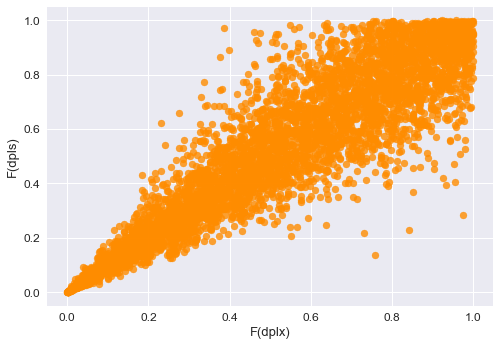

In [42]:
#simulating with this Clayton copula
from pycop.bivariate import simulation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn') 
u1, u2 = simulation.simu_clayton(num=5000, theta=dist4.theta)
plt.scatter(u1, u2, color="darkorange", alpha=0.8)
plt.xlabel("F(dplx)", fontsize=13)
plt.ylabel("F(dpls)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('cop_dplx_dpls.png', dpi=300, bbox_inches='tight')